# CSV Insight Visualization

This Jupyter notebook visualizes JSON reports generated by [CsvInsight](https://pypi.org/project/csvinsight/) for a particular DBI2 Job.

You'll need a magic URL from the DBI2 server.
If everything worked as planned, the notebook grabbed the magic URL automatically, fetched the contents, and rendered them below.

If it looks like things aren't going according to plan, you can try to start the process manually:

1. In the menu at the top of the screen, select "Kernel/Restart & Run All"
2. Paste the magic URL for csv_insight.json at the prompt
3. Click on the button below (optional) to hide code

In [1]:
# Parameters:

In [2]:
%%html
<script>
var show_code = false; 
function code_toggle() {
  if (show_code) {
      $('div.input').hide();
  } else { 
      $('div.input').show(); 
  }
  show_code = !show_code;
} 
$(document).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle code">
</form>

In [3]:
#
# Load the data we'll plotting.
# It will be available via the ``D`` global variable.
#

import base64
import json
import getpass
import requests

try:
    with open('local.json') as fin:
        D = json.load(fin)
except Exception:
    if 'MAGIC_URL' in globals():
        #
        # The MAGIC_URL arrived via the querystring, so it needs to be
        # unescaped first.
        #
        MAGIC_URL = base64.b64decode(MAGIC_URL).decode('utf-8')
    else:
        MAGIC_URL = getpass.getpass("Paste the magic URL: ")

    D = requests.get(MAGIC_URL).json()
    
    # with open('local.json', 'w') as fout:
    #    json.dump(D, fout)

Paste the magic URL: ········


In [4]:
#
# Field descriptions are only available for local notebooks,
# because we don't want to keep that data public.
#
import yaml
import pathlib

try:
    # path = pathlib.Path(os.getcwd()).parents[0] / 'dbi2/dbi2/fields.yml'
    path = '/home/misha/pn/dbi2/dbi2/fields.yml'
    with open(path) as fin:
        FIELD_INFO = {f['name']: f for f in yaml.load(fin, Loader=yaml.CLoader)}
except Exception:
    FIELD_INFO = {}

In [5]:
#
# Cache the geojson locally so we can re-run the notebook
# without network access, if necessary.
#
try:
    with open('geo.json') as fin:
        geo_json = json.load(fin)
except FileNotFoundError:
    r = requests.get('https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_0_countries.geojson')
    geo_json = r.json()
    
    with open('geo.json', 'w') as fout:
        json.dump(geo_json, fout)

In [6]:
import json
import os
import re

import folium
import matplotlib
import matplotlib.pyplot as plt
import requests

import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets

import yaml

from IPython.display import display, HTML, Markdown
from ipywidgets import interact, interactive, widgets

%matplotlib inline

PALLETTE = 'deep'
sns.set(palette=PALLETTE)

FIGSIZE = (8, 6)

/home/misha/envs/dbi2/lib/python3.6/site-packages/scipy/__init__.py:115: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.13.1)
  UserWarning)


In [7]:
#
# Some helper functions for plotting.
# Feel free to use them when making your own plots, 
# or read from the global ``D`` variable instead.
#

def plot_pie_chart(labels, values, title='', size=FIGSIZE):
    """Plot a pie chart.
    
    :param list labels:
    :param list values:
    :param str title: An optional title for the chart.
    """
    fig, ax = plt.subplots(figsize=size)
    ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)
    ax.axis('equal')
    if title:
        ax.set_title(title, fontsize=20, y=1.02)
    plt.show()


def plot_horizontal_bar(column, top=None,
                        y_label=None, x_label='Frequency', log_scale=False, figsize=FIGSIZE):
    """Plot the most common values for a single column in the original CSV data.
    
    The column should contain numeric values only.
    The result is a horizontal bar chart.
    
    :param str column: The column name.
    :param int top:
    :param str y_label: The label for the Y axis.
    :param str x_label: The label for the X axis.
    :param boolean log_scale: Set this to True to use the logarithmic scale.
    
    Reads the actual data from the global variable.
    """
    try:
        values, labels = zip(*D['results'][column]['most_common'])
    except KeyError:
        # missing column
        return
    fig, ax = plt.subplots(figsize=figsize)
    # sns.set(palette='pastel')
    data = pd.DataFrame({'values': values, 'labels': labels})
    
    data['labels'] = data['labels'].astype(str)
    data['values'] = data['values'].astype(int)
    data = data[data['labels'] != '']
        
    if top:
        data = data.head(top)
    if y_label is None:
        y_label = column
    if log_scale:
        x_label = 'Log ' + x_label

    y_pos = np.arange(len(data))
    ax.barh(y_pos, data['values'], align='center', color='b', ecolor='black')
    #ax.set_title(column)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(data['labels'])
    ax.set_ylim(len(data) - 0.3, -0.7, auto=None)

    ax.set(xlabel=x_label, ylabel=y_label)
    ax.xaxis.set_tick_params(width=4, length=5, which='major')
    ax.xaxis.set_tick_params(width=2, length=5, which='minor')
    ax.xaxis.grid(False)

    #ax.xaxis.set_ticks_position('both')
    #ax.tick_params(labelbottom=False, labeltop=False)
    
    if log_scale:
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter(''))
        ax.xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=60)
        ax.xaxis.grid(True, linestyle='--', which='minor', color='grey', alpha=0.25)
        
    return ax


def plot_hist(column, log=False, density=True, bins=25,
              figsize=FIGSIZE, y_label='Frequency', x_label='', x_range=None):
    """Plot a histogram of the most common values for a particular column.
    
    The column may contain non-numeric values.
    
    :param str column: The name of the column.
    :param boolean log: Set this to True to use a logarithmic scale.
    :param boolean density: If True, plots a probability density instead of the raw counts.
    :param int bins: The number of bins in the histogram.
    :param tuple figsize:
    :param str y_label: The label for the Y axis.
    :param str x_label: The label for the X axis.
    :param tuple x_range: The range for the X axis.
    
    Reads the actual data from the global variable.
    
    """
    df = pd.DataFrame(D['results'][column]['most_common'], columns=['frequency', 'label'])
    df = df[df['label'] != '']
    df['label'] = df['label'].astype(float)
    if x_range:
        df = df[(df['label'] >= x_range[0]) & (df['label'] <= x_range[1])]

    fig, ax = plt.subplots(figsize=figsize)

    ax.hist(df['label'], weights=df['frequency'], density=density, bins=bins, log=log, color='b')
    if log:
        y_label = 'Log ' + y_label
        ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    ax.set(xlabel=x_label, ylabel=y_label)
    return ax


def select_values(column, pattern, top=None):
    """Select a subset of the most common values for a particular column.
    
    :param str column: The column name.
    :param str pattern: A regular expression for filtering the values.
    :param int top: If non-None, restricts the selection to the top ``N`` values.
    :rtype: tuple of (list, list)
    :returns: Two lists of equal length.  The second list contains values.  The first list
    contains frequencies (counts) for the corresponding value.
    """
    data = list(filter(lambda x: re.search(pattern, x[1]), D['results'][column]['most_common']))
    if top:
        other = (sum([x[0] for x in data[top:]]), 'other categories')
        data = data[0:top]
        if other[0] > 0:
            data.append(other)
    return zip(*data)


def get_min_max(column, index=0):
    """Get the minimum and maximum values for a particular column."""
    vals = list(zip(*D['results'][column]['most_common']))
    non_empty_vals = [float(x) for x in vals[index] if x != '']
    return min(non_empty_vals), max(non_empty_vals)


def display_field_info(header, field):
    """Return a description for a particular column.
    
    :param str header:
    :param str field:
    """
    try:
        description = FIELD_INFO[field].get('description')
    except KeyError:
        md = Markdown('%s' % header)
    else:
        md = Markdown("""%s 

Field name: `%s`  
Field description: %s  
""" % (header, field, description))
    
    display(md)


def remove_absent_fields(fields):
    """Return only fields that are present in the dataset."""
    return [f for f in fields if f in D['results']]

#
# End of reusable code section.
# Everything below is generally too field-specific to be useful in the general case.
#

In [8]:
Markdown('#### Number of domains: %s'%(D['results']['domain']['num_values']))

#### Number of domains: 1019014

## CSV Insight fields summary

In [9]:
def construct_summary():
    """Construct a summary of the report as a Pandas DataFrame."""
    summary_fields = [
        'field', 'num_values', 'num_fills', 'fill_rate',
        'max_len', 'min_len', 'avg_len', 'num_uniques',
    ]

    df = []
    for field, data in D['results'].items():
        row = dict(data)
        row['field'] = field
        df.append(row)
    df = pd.DataFrame(df)
    return df[summary_fields].sort_values('field')

with pd.option_context('display.max_rows', 100):
    display(construct_summary())

,field,num_values,num_fills,fill_rate,max_len,min_len,avg_len,num_uniques
34,advertising,1288595,467633,36.290145,26,0,5.076940,118
45,backend,1019014,1019013,99.999902,6,0,5.999994,2
221,backlinks_2017q4,1019014,1019014,100.000000,8,1,2.474970,13872
220,backlinks_2018q1,1019014,1019014,100.000000,8,1,2.526170,14562
219,backlinks_2018q2,1019014,1019014,100.000000,8,1,2.558029,14959
218,backlinks_2018q3,1019014,1019014,100.000000,8,1,2.568490,14702
217,backlinks_2018q4,1019014,1019014,100.000000,8,1,2.604693,15148
216,backlinks_2019q1,1019014,1019014,100.000000,8,1,2.625205,14738
215,backlinks_2019q2,1019014,1019014,100.000000,8,1,2.677093,14980
214,backlinks_2019q3,1019014,1019014,100.000000,8,1,2.739987,14988


# Domain classification 

Field name: `domain_classification_out`  
Field description: High level classification for a Domain.
For the confidence of the classification, see the domain_classification_score_out field.  


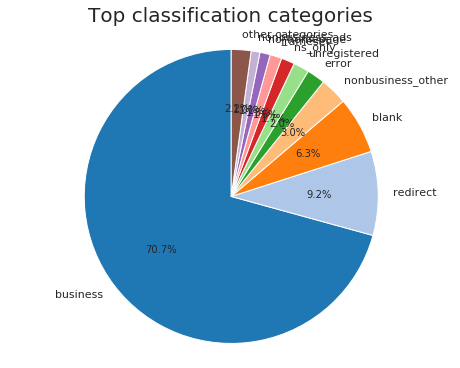

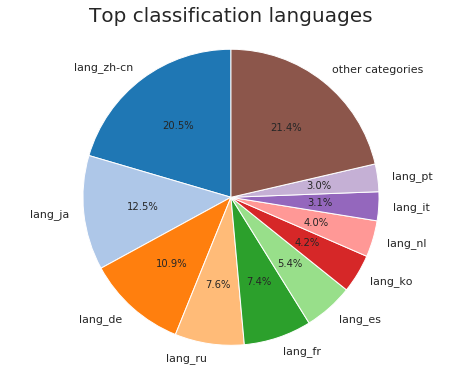

In [10]:
def get_first_field_name(*fields):
    """Return the first name that is present in the dataset.
    
    Returns None if all fields are absent.
    """
    for f in fields:
        if f in D['results']:
            return f
        
    return None


classification_field = get_first_field_name('domain_classification_out', 'domain_classification')
if classification_field:
    display_field_info('# Domain classification', classification_field)
    
    values, labels = select_values(classification_field, pattern='^(?!lang_).*$', top=10)
    plot_pie_chart(labels, values, title='Top classification categories')

    values, labels = select_values(classification_field, pattern='^lang.*$', top=10)
    plot_pie_chart(labels, values, title='Top classification languages')

## Histogram of `domain_classification_score_out` 

Field name: `domain_classification_score_out`  
Field description: The confidence for the classification in the domain_classification_out field.
Follow the guide below to interpret this confidence:
- 0 :math:`\leq` ``value`` :math:`\leq` 0.6: low confidence
- 0.6 < ``value`` < 0.8: medium confidence
- 0.8 < ``value`` < 0.9: high confidence
- 0.9 < ``value`` :math:`\leq` 1.0: very high confidence
  


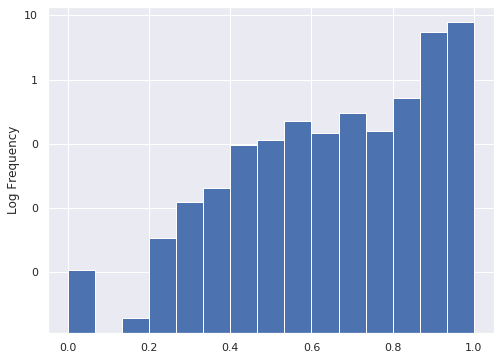

In [11]:
score_field = get_first_field_name('domain_classification_score_out', 'domain_classification_score')
if score_field:
    display_field_info('## Histogram of `%s`' % score_field, score_field)
    plot_hist(score_field, log=True, bins=15);

## Most common manual labels 

Field name: `domain_classification_manual`  
Field description: High-level classification for a domain, specified manually.
This manual classification happens *instead* of the DomainClassify classification in the domain_classification field.  


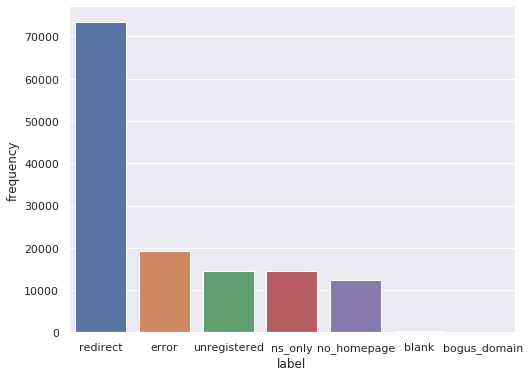

In [12]:
try:
    D['results']['domain_classification_manual']
except KeyError:
    # missing domain_classification_manual field
    pass
else:
    
    df = pd.DataFrame(D['results']['domain_classification_manual']['most_common'], columns=['frequency', 'label'])
    df = df[df.label != '']

    if len(df):
        display_field_info("## Most common manual labels", 'domain_classification_manual')
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.barplot(x="label", y="frequency", data=df, ax=ax);

In [13]:
density_fields = [
    'primary_density',
    'dns_density',
    'cloud_density',
    'iaas_density',
    'paas_density',
    'saas_density',
    'saas_density_by_duns',
    'cloud_density_by_duns',
    'paas_density_by_duns',
    'iaas_density_by_duns',
]

# Avoid trying to plot fields that aren't in the report
# Some flavors don't include particular fields
density_fields = remove_absent_fields(density_fields)


def plot_density(field):
    """Plot a non-historic density field (e.g. primary_density) as a histogram.
    
    :param str field: The name of the field.
    
    """
    use_log, bins = {
        'primary_density': (False, 6),
        'dns_density': (False, 10),
        'cloud_density': (True, 9),
        'iaas_density': (True, 32),
        'paas_density': (True, 5),
        'saas_density': (True, 7),
        'saas_density_by_duns': (True, 20),
        'cloud_density_by_duns': (True, 20),
        'paas_density_by_duns': (True, 20),
        'iaas_density_by_duns': (True, 20),
    }[field]
    
    # TODO: fixme non-integer bins look odd
    
    display_field_info('## Histogram of `%s`' % field, field)
    ax = plot_hist(field, log=use_log, figsize=(8, 6), bins=bins)
    if bins > 20:
        ax.set_xticks(range(bins))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=-90)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    plt.show()


if density_fields:
    dropdown = widgets.Dropdown(options=density_fields, description='Field:')
    widget = widgets.interactive(plot_density, field=dropdown)

    display(Markdown("# Density fields"))
    display(widget)

# Density fields

interactive(children=(Dropdown(description='Field:', options=('primary_density', 'dns_density', 'cloud_density…

In [14]:
div_fields = [
    'cloud_diversification',
    'iaas_diversification',
    'paas_diversification',
    'saas_diversification',
    'cloud_diversification_by_duns',
    'iaas_diversification_by_duns',
    'paas_diversification_by_duns',
    'saas_diversification_by_duns',
]


def plot_diversification(field):
    """Plot a diversification field (e.g. cloud_diversification) as a histogram.
    
    :param str field: The field to plot.
    """
    
    use_log, bins = {
        'cloud_diversification': (True, 9),
        'iaas_diversification': (True, 32),
        'paas_diversification': (True, 4),
        'saas_diversification': (True, 7),
        'cloud_diversification_by_duns': (True, 11),
        'iaas_diversification_by_duns': (True, 20),
        'paas_diversification_by_duns': (True, 6),
        'saas_diversification_by_duns': (True, 11),
    }[field]

    display_field_info('## Histogram of `%s`' % field, field)

    try:
        ax = plot_hist(field, log=use_log, figsize=(8, 6), bins=bins)
    except KeyError:
        return
    if bins > 20:
        ax.set_xticks(range(bins))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=-90)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    plt.show()


present_fields = [f for f in div_fields if f in D['results']]    

if present_fields:
    dropdown = widgets.Dropdown(options=present_fields, description='Field:')
    widget = widgets.interactive(plot_diversification, field=dropdown)
    display(Markdown("# Diversification fields"))
    display(widget)

# Diversification fields

interactive(children=(Dropdown(description='Field:', options=('cloud_diversification', 'iaas_diversification',…

# Binary fields summary

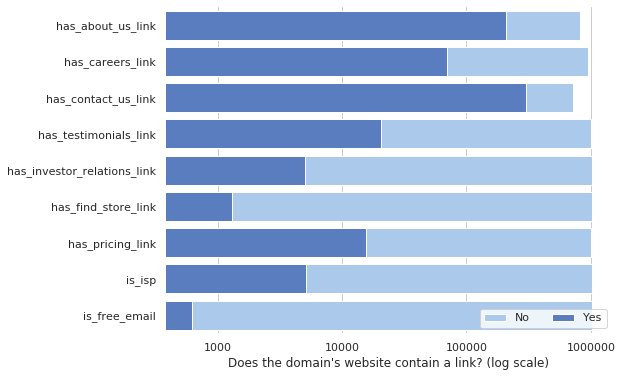

has_about_us_link: Does the domain's website contain an "About Us" link?
The presence of such a link may indicate that the domain belongs to a business.  
has_careers_link: Does the domain's website contain a "Careers" link?
The presence of such a link indicates the domain employs people, and may be a business.  
has_contact_us_link: Does the domain's website contain a "Contact Us" link?
The presence of such a link indicates the domain may be a business.  
has_testimonials_link: Does the domain's website contain a "Testimonials" link?
The presence of such a link indicates the domain has a product or service, and may be a business.  
has_investor_relations_link: Does the domain's website contain a "Investor Relations" link? The presence of such a link indicates the domain is a business.  
has_find_store_link: Does the domain's website contain a "Find a Store" link?
The presence of such a link indicates the domain is a business with physical store locations.  
has_pricing_link: Does the domain's website contain a "Pricing or Plans" link?
The presence of such a link indicates the domain has a product or service, and may be a business.  
is_isp: Whether this domain belongs to an ISP.  
is_free_email: Whether this domain provides email addresses for free.  


,No,Yes,% Yes
label,,,
has_about_us_link,811381,207633,25.590074
has_careers_link,949093,69921,7.367139
has_contact_us_link,717737,301277,41.975961
has_testimonials_link,998515,20499,2.052949
has_investor_relations_link,1013954,5060,0.499036
has_find_store_link,1017696,1318,0.129508
has_pricing_link,1003455,15559,1.550543
is_isp,1013848,5166,0.509544
is_free_email,1018394,620,0.060880


In [15]:
binary_fields = [
    'has_about_us_link',
    'has_careers_link',
    'has_contact_us_link',
    'has_testimonials_link',
    'has_investor_relations_link',
    'has_find_store_link',
    'has_pricing_link',
    'is_isp',
    'is_free_email'
]


def prepare_binary_data(field):
    most_common =  {
        rec[1]:rec[0]
        for rec in D['results'][field]['most_common']        
    }
    return  {
        'label': field, 
        'Yes': most_common['Y'],
        'No': most_common['N'],
    }
    

try:
    binary_fields = pd.DataFrame(
        [
            prepare_binary_data(field)
            for field in binary_fields
            if field in D['results']
        ]
    )[['label', 'No', 'Yes']]
except KeyError:
    # no binary fields in report
    pass
else:
    binary_fields['% Yes'] = (binary_fields['Yes'] / binary_fields['No']) * 100
    
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(8, 6))
    sns.set_color_codes("pastel")

    no_ax = sns.barplot(x="No", y="label", data=binary_fields, label="No", color="b")
    no_ax.set_xscale('log')

    sns.set_color_codes("muted")
    yes_ax = sns.barplot(x="Yes", y="label", data=binary_fields, label="Yes", color="b")
    yes_ax = yes_ax.set_xscale('log')

    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel="", xlabel="Does the domain's website contain a link? (log scale)")
    sns.despine(left=True, bottom=True)
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))

    description = ''
    for field in binary_fields['label']:
        try:
            field_description = '%s: %s  \n'%(field, FIELD_INFO[field]['description'])
        except KeyError:
            pass
        else:
            description += field_description
    display(Markdown('# Binary fields summary'))
    plt.show()
    display(Markdown(description))
    display(binary_fields.set_index('label'))

# Top values for text or categorical fields

In [16]:
def trap_key_error(func):
    def wrap(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except KeyError:
            pass
    return wrap


def plot_top(field, n, log_scale):
    display_field_info("## Top %s `%s` values"%(n, field), field)

    plot_horizontal_bar(field, log_scale=log_scale, top=n, figsize=(8, 6))
    plt.show()
    
    df = pd.DataFrame(D['results'][field]['most_common'], columns=['frequency', 'label'])
    df = df[df['label'] != '']
    display(df.head(n)[['label', 'frequency']])
    

categorical_fields = [
    'cloud_company',
    'dns_a_hostnames',
    'dns_a_ips',
    'dns_soa_mnames',
    'dns_soa_rnames',
    'hosting_company',
    'hosting_domain',
    'hp_return_codes',
    'iaas_company',
    'ip_block_owner_domain',
    'ip_block_owner',
    'mail_server',
    'mail_server_domain',
    'mail_server_provider',
    'mail_server_ip'
    'naics_description',
    'name_pn',
    'nameserver_domains',
    'nameservers',
    'orb_name',
    'paas_company',
    'saas_company',
    'sic_description',
    'ssl_certificate_issuer', 
    'subdomain_networks',
    'we_address1',
    'we_address2',
    'we_city',
    'we_company',
    'we_contact_page',
    'we_details',
    'we_phone',
    'we_state',
    'we_status',
    'we_zip',
    'web_server_type',
    'website_ip',
    'ip_block_owner_domain',
    'hosting_range_domain',
]
categorical_fields = sorted(remove_absent_fields(categorical_fields))

if categorical_fields:
    dropdown = widgets.Dropdown(options=categorical_fields, description='Field:')
    slider = widgets.IntSlider(value=20, min=5, max=50, description='Max items:')
    log_scale = widgets.Checkbox(value=True,description='Use log scale', disabled=False)

    widget = widgets.interactive(plot_top, field=dropdown, n=slider, log_scale=log_scale)
    display(widget)

interactive(children=(Dropdown(description='Field:', options=('cloud_company', 'dns_a_hostnames', 'dns_a_ips',…

In [17]:
fingerprint_fields =  [
    'web_analytics', 'web_technology_tools', 'social_networks',
    'advertising', 'cms', 'ecommerce'
]
fingerprint_fields = sorted(remove_absent_fields(fingerprint_fields))


def plot_fp_category(field):
    display_field_info('### Top 20 fingerprints in the `%s` category' % field, field)
    plot_horizontal_bar(field, log_scale=True, top=20)
    plt.show();


if fingerprint_fields:
    dropdown = widgets.Dropdown(options=fingerprint_fields, description='Category:')
    widget = widgets.interactive(plot_fp_category, field=dropdown)

    display(Markdown("# Fingerprints"))
    display(widget)

# Fingerprints

interactive(children=(Dropdown(description='Category:', options=('advertising', 'cms', 'ecommerce', 'social_ne…

In [18]:
def make_choropleth(column_name, skip_empty=True, value_field_name='Domains'):
    """Create a choropleth.
    
    The color of each country is proportional to its frequency in the specified column name.
    Frequently occuring countries will be darker.
    
    The choropleth is interactive.
    If you mouse over a country, you'll see a mouse-over with details.
    
    :param str column_name: The column name to read data from.  Must contain ISO2 country codes.
    :param boolean skip_empty: Skip empty values when reading the data.
    :param str value_field_name: The field name to show in the mouse-over.
    
    :rtype: folium.Map
    """
    data = pd.DataFrame(D['results'][column_name]['most_common'], columns=['value','country'])
    if skip_empty:
        data = data[data['country'] != '']
    
    data['log_value'] = np.log2(data['value'])
    data['log_value'] = data['log_value'] - data['log_value'].min()
    
    data = data.set_index('country')
    for item in geo_json['features']:
        code = item['properties']['iso_a2']
        item['properties']['domains'] = int(data['value'].get(code, 0))
    data = data.reset_index()
        
    m = folium.Map(tiles='Mapbox Bright', location=[45.060262, -32.099606], zoom_start=2)
    f = folium.Choropleth(
        geo_data=geo_json,
        data=data,
        columns=['country', 'log_value'],
        key_on='feature.properties.iso_a2',
        fill_color='YlGnBu',
        fill_opacity=0.6,
        line_opacity=0.4,
        nan_fill_color='white',
        nan_fill_opacity=0.1,
        legend_name='Relative log frequency',
        highlight=True,
        overlay=False,
    ).add_to(m)

    folium.GeoJsonTooltip(fields=['name', 'domains'], aliases=['Country', value_field_name], labels=True, sticky=True).add_to(f.geojson)
    return m


def plot_country_field(field):
    display_field_info('### Choropleth for `%s` field' % field, field)
    display(make_choropleth(field, value_field_name='count'))


country_code_fields = [
    'mail_server_ip_cc',
    'website_ip_cc',
    'dns_a_ips_cc',
    'merged_country',
    'country_code_pn',
    'we_country',
    'orb_country',
]

country_code_fields = [f for f in country_code_fields if f in D['results']]

if country_code_fields:
    dropdown = widgets.Dropdown(options=country_code_fields, description='Field:')
    widget = widgets.interactive(plot_country_field, field=dropdown)

    display(Markdown("# Country fields"))
    display(widget)

# Country fields

interactive(children=(Dropdown(description='Field:', options=('mail_server_ip_cc', 'website_ip_cc', 'dns_a_ips…

# Revenue range 

Field name: `revenue_range`  
Field description: The revenue range from the ORB dataset.  


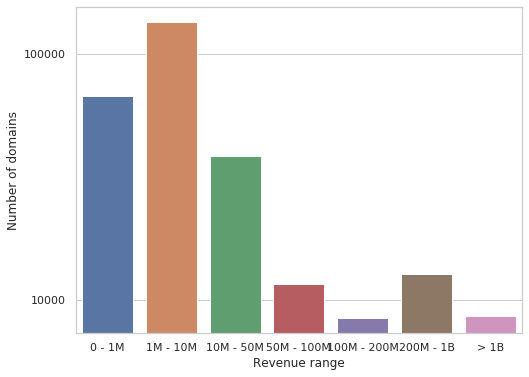

In [19]:
rev_order = ['0 - 1M', '1M - 10M', '10M - 50M', '50M - 100M', '100M - 200M', '200M - 1B', '> 1B']
try:
    df = pd.DataFrame(D['results']['revenue_range']['most_common'], columns=['frequency', 'label'])
except KeyError:
    pass
else:
    df = df[df['label'] != '']
    fig, ax = plt.subplots(figsize=(8, 6))
    display_field_info('# Revenue range', 'revenue_range')

    sns.barplot(data=df, x='label', y='frequency', ax=ax, order=rev_order)
    ax.set_yscale('log')
    ax.set(xlabel='Revenue range', ylabel='Number of domains')
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))

# Employee range 

Field name: `employee_range`  
Field description: The range that the company's employee count falls into.  


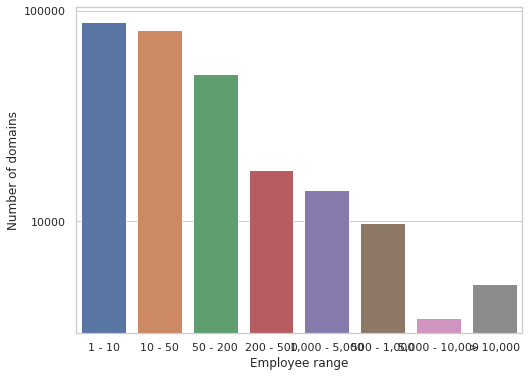

In [20]:
employee_order = [
    '1 - 10', '10 - 50', '50 - 200', '200 - 500',
    '1,000 - 5,000', '500 - 1,000', '5,000 - 10,000',
    '> 10,000',
]
try:
    df = pd.DataFrame(D['results']['employee_range']['most_common'], columns=['frequency', 'label'])
except KeyError:
    pass
else:
    df = df[df['label'] != '']
    fig, ax = plt.subplots(figsize=(8, 6))
    display_field_info('# Employee range', 'employee_range')

    sns.barplot(data=df, x='label', y='frequency', ax=ax, order=employee_order)
    ax.set_yscale('log')
    ax.set(xlabel='Employee range', ylabel='Number of domains')
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))

In [21]:
def plot_year_founded(x_range):
    try:
        df = pd.DataFrame(D['results']['year_founded']['most_common'], columns=['frequency', 'label'])
    except KeyError:
        pass
    else:
        df = df[df['label'] != '']
        df['label'] = df['label'].astype(float)
        df = df[(df['label'] >= x_range[0]) & (df['label'] <= x_range[1])]
        fig, ax = plt.subplots(figsize=(8, 6))
        
        ax.hist(df['label'], weights=df['frequency'], density=False, bins=28, log=True, color='b')
        ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        ax.set(xlabel='year', ylabel='Number of domains (actual values plotted on the log scale)');


try:
    min_year, max_year = get_min_max('year_founded', index=1)
except KeyError:
    pass
else:
    slider = widgets.IntRangeSlider(
        value=(min_year, max_year), min=min_year, max=2019, description='Year range:',
       continuous_update=False, layout={'width': '40%'}
    )
    widget = widgets.interactive(plot_year_founded, x_range=slider)

    display_field_info('# Year founded', 'employee_range')
    display(widget)

# Year founded 

Field name: `employee_range`  
Field description: The range that the company's employee count falls into.  


interactive(children=(IntRangeSlider(value=(1907, 2016), continuous_update=False, description='Year range:', l…

In [22]:
@trap_key_error
def plot_last_funding(x_range):
    df = pd.DataFrame(D['results']['last_funding_round_year']['most_common'], columns=['frequency', 'label'])
    df = df[df['label'] != '']
    df['label'] = df['label'].astype(float)
    df = df[(df['label'] >= x_range[0]) & (df['label'] <= x_range[1])]
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.hist(df['label'], weights=df['frequency'], density=False, bins=28, log=True, color='b')
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    ax.set(xlabel='year', ylabel='Number of domains (actual values plotted on the log scale)');


try:
    min_year, max_year = get_min_max('last_funding_round_year', index=1)
except KeyError:
    pass
else:
    slider = widgets.IntRangeSlider(
        value=(min_year, max_year), min=min_year, max=max_year, description='Year range:',
       continuous_update=False, layout={'width': '40%'}
    )
    widget = widgets.interactive(plot_last_funding, x_range=slider)

    display_field_info('# Last funding round year', 'last_funding_round_year')
    display(widget)

# Last funding round year 

Field name: `last_funding_round_year`  
Field description: The last funding round year from the Orb dataset.  


interactive(children=(IntRangeSlider(value=(1987, 2016), continuous_update=False, description='Year range:', l…

In [23]:
def plot_last_fund_round(x_range):
    df = pd.DataFrame(D['results']['last_funding_round_amount']['most_common'], columns=['frequency', 'label'])
    df = df[df['label'] != '']
    df['label'] = df['label'].astype(float)
    df = df[(df['label'] >= x_range[0]) & (df['label'] <= x_range[1])]
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.hist(df['label'], weights=df['frequency'], density=False, bins=28, log=True, color='b')
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    ax.set(xlabel='year', ylabel='Number of domains (actual values plotted on the log scale)');


try:
    min_year, max_year = get_min_max('last_funding_round_amount', index=1)
except KeyError:
    pass
else:
    slider = widgets.IntRangeSlider(
        value=(min_year, max_year), min=min_year, max=max_year,
        description='Amount:',continuous_update=False, 
        layout={'width': '50%'}
    )
    widget = widgets.interactive(plot_last_fund_round, x_range=slider)
    
    display_field_info('# Last funding round amount', 'last_funding_round_amount')
    display(widget)

# Last funding round amount 

Field name: `last_funding_round_amount`  
Field description: The last funding round amount from the Orb dataset.  


interactive(children=(IntRangeSlider(value=(10000, 200000000), continuous_update=False, description='Amount:',…

In [24]:
def plot_total_raised(x_range):
    df = pd.DataFrame(D['results']['last_funding_round_amount']['most_common'], columns=['frequency', 'label'])
    df = df[df['label'] != '']
    df['label'] = df['label'].astype(float)
    df = df[(df['label'] >= x_range[0]) & (df['label'] <= x_range[1])]
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.hist(df['label'], weights=df['frequency'], density=False, bins=28, log=True, color='b')
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    ax.set(xlabel='year', ylabel='Number of domains (actual values plotted on the log scale)');


try:
    min_year, max_year = get_min_max('total_amount_raised', index=1)
except KeyError:
    pass
else:
    slider = widgets.IntRangeSlider(
        value=(min_year, max_year), min=min_year, max=max_year,
        description='Amount:',continuous_update=False, layout={'width': '50%'}
    )
    widget = widgets.interactive(plot_total_raised, x_range=slider)

    display_field_info('# Last funding round amount', 'total_amount_raised')
    display(widget)

# Last funding round amount 

Field name: `total_amount_raised`  
Field description: The total amount raised from the Orb dataset.  


interactive(children=(IntRangeSlider(value=(10000, 100000000), continuous_update=False, description='Amount:',…

In [25]:
count_fields = [
    'external_links_homepage_count',
    'unique_email_user_count',
    'subdomain_count',
    'web_server_count',
    'subdomain_count',
    'local_links_homepage_count',
    'local_links_level_2_count',
    'external_links_homepage_count',
    'external_links_level_2_count',
    'number_of_domains_linked',
    'employee',
    'twitter_followers',
    'facebook_likes'
]
count_fields = sorted([f for f in count_fields if f in D['results']])


def plot_count(field, x_range):
    display_field_info('## Histogram of the `%s` field' % field, field)
    plot_hist(field, log=True, x_range=x_range)
    plt.show();
    df = pd.DataFrame(D['results'][field]['most_common'], columns=['frequency', 'label'])
    df = df[df['label'] != '']
    display(Markdown("## Top 25 values"))
    display(df.head(30)[['label', 'frequency']])

try:
    field_name = count_fields[0]
except (KeyError, IndexError):
    pass
else:
    min_count, max_count = get_min_max(field_name, index=1)
    slider = widgets.IntRangeSlider(
        value=(min_count, max_count), min=min_count, max=max_count,
        description='Range:', continuous_update=False, 
        layout={'width': '50%'}
    )
    dropdown = widgets.Dropdown(options=count_fields, description='Field:')
    def on_change(v):
        min_count, max_count = get_min_max(v['new'], index=1)
        slider.min = min_count
        slider.max = max_count
        slider.value = [min_count, max_count]
    dropdown.observe(on_change, names='value')
    widget = widgets.interactive(plot_count, field=dropdown, x_range=slider)

    display(Markdown("# Count fields"))
    display(widget)
    

# Count fields

interactive(children=(Dropdown(description='Field:', options=('employee', 'external_links_homepage_count', 'ex…

In [26]:
def plot_dc_quarter(quarter):
    display_field_info('', quarter)
    ax = plot_hist(quarter, log=True, figsize=(8, 6))
    
device_count_fields = sorted([x for x in D['results'].keys() if x.find('device_count') == 0])

if device_count_fields:
    dropdown = widgets.Dropdown(options=device_count_fields, description='Quarter:')
    widget = widgets.interactive(plot_dc_quarter, quarter=dropdown)

    display(Markdown("# Device counts"))
    display(widget)

# Device counts

interactive(children=(Dropdown(description='Quarter:', options=('device_count_2017q1', 'device_count_2017q2', …

In [27]:
def plot_density_quarter(quarter):
    display_field_info('', quarter)
    ax = plot_hist(quarter, log=True, figsize=(8, 6))
    
density_q_fields = sorted([x for x in D['results'].keys() if re.search('dbi_density_[0-9]{4}q[0-9]', x)])

dropdown = widgets.Dropdown(options=density_q_fields, description='Quarter:')
widget = widgets.interactive(plot_density_quarter, quarter=dropdown)
    
display(Markdown("# DBI density"))
display(widget)

# DBI density

interactive(children=(Dropdown(description='Quarter:', options=('dbi_density_2017q1', 'dbi_density_2017q2', 'd…

In [28]:
def plot_backlinks_quarter(quarter):
    display_field_info('', quarter)
    ax = plot_hist(quarter, log=True, figsize=(8, 6))
    
backlinks_fields = sorted([x for x in D['results'].keys() if 'backlinks_' in x])
if backlinks_fields:
    dropdown = widgets.Dropdown(options=backlinks_fields, description='Quarter:')
    widget = widgets.interactive(plot_backlinks_quarter, quarter=dropdown)

    display(Markdown("# Backlinks"))
    display(widget)

# Backlinks

interactive(children=(Dropdown(description='Quarter:', options=('backlinks_2017q4', 'backlinks_2018q1', 'backl…

In [29]:
def plot_sptb_quarter(quarter):
    display_field_info('', quarter)
    ax = plot_hist(quarter, log=True, figsize=(8, 6),x_label='SPTB score')

sptb_fields = sorted([x for x in D['results'] if re.search('sptb_score_[0-9]{4}q[0-9]', x)])
if sptb_fields:
    dropdown = widgets.Dropdown(options=sptb_fields, description='Quarter:')
    widget = widgets.interactive(plot_sptb_quarter, quarter=dropdown)

    display(Markdown("# SPTB score"))
    display(widget)

# SPTB score

interactive(children=(Dropdown(description='Quarter:', options=('sptb_score_2017q1', 'sptb_score_2017q2', 'spt…

In [30]:
def plot_sptb_rank_quarter(quarter):
    display_field_info('', quarter)
    fig, ax = plt.subplots(figsize=(8, 6))
    df = pd.DataFrame(D['results'][quarter]['most_common'], columns=['frequency', 'label'])
    df = df[df.label != '']
    sns.barplot(x="label", y="frequency", data=df, ax=ax);
    ax.set(xlabel='SPTB rank', ylabel='Frequency (log scale)')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    return ax
    
sptb_rank_fields = sorted([x for x in D['results'].keys() if re.search('sptb_rank_[0-9]{4}q[0-9]', x)])
if sptb_rank_fields:
    dropdown = widgets.Dropdown(options=sptb_rank_fields, description='Quarter:')
    widget = widgets.interactive(plot_sptb_rank_quarter, quarter=dropdown)

    display(Markdown("# SPTB rank"))
    display(widget)

# SPTB rank

interactive(children=(Dropdown(description='Quarter:', options=('sptb_rank_2017q1', 'sptb_rank_2017q2', 'sptb_…

In [31]:
def plot_ctj_quarter(quarter):
    fig, ax = plt.subplots(figsize=(8, 6))
    if quarter:
        display_field_info('', quarter)

        df = pd.DataFrame(D['results'][quarter]['most_common'], columns=['frequency', 'label'])
        df = df[df.label != '']
        sns.barplot(x="label", y="frequency", data=df, ax=ax);
        plt.ticklabel_format(style='plain', axis='y')
    
    ax.set(xlabel='CTJ score')
    return ax
    
ctj_fields = sorted([x for x in D['results'].keys() if re.search('ctj_score_[0-9]{4}q[0-9]', x)])
if ctj_fields:
    dropdown = widgets.Dropdown(options=ctj_fields, description='Quarter:')
    widget = widgets.interactive(plot_ctj_quarter, quarter=dropdown)

    display(Markdown("# CTJ score"))
    display(widget)

# CTJ score

interactive(children=(Dropdown(description='Quarter:', options=('ctj_score_2017q1', 'ctj_score_2017q2', 'ctj_s…

## DBI2 density history 

Field name: `dbi_density_2018q1`  
Field description: None  


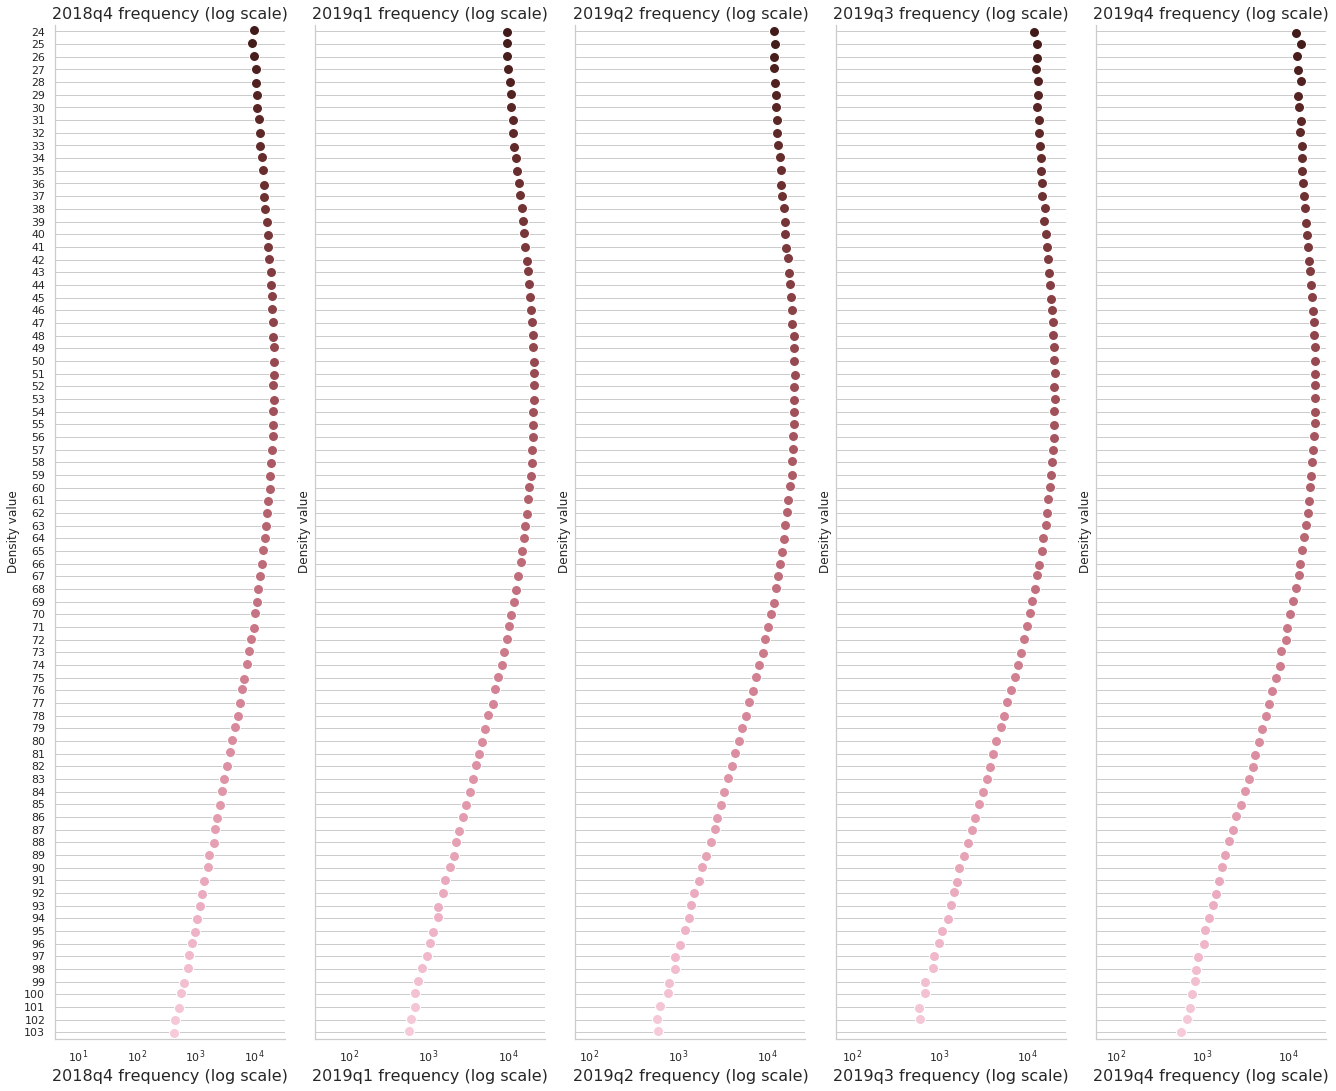

In [32]:
def make_pair_plot(key_pattern, top_q=5, y_label='Density value'):
    sns.set(style="whitegrid")
    fields = list(filter(lambda x: re.search(key_pattern, x), D['results'].keys()))
    df = None
    for f in fields:
        subdf = pd.DataFrame(D['results'][f]['most_common'], columns=[f, 'label'])
        subdf = subdf[subdf['label'] != '']
        subdf = subdf.set_index('label')

        if df is None:
            df = subdf
        else:
            df = df.join(subdf)

    columns = sorted(df.columns)[-top_q:]
    df = df.reset_index()
    df['label'] = df['label'].astype(int)
    df = df.sort_values('label', ascending=False).head(80)
    g = sns.PairGrid(df, x_vars=columns, y_vars=["label"], height=15, aspect=.25)
    g.map(sns.stripplot, size=10, orient="h", palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")
    g.set(ylabel=y_label)
    for ax, title in zip(g.axes.flat, columns):
        ax.set_title(label=title[-6:] + ' frequency (log scale)', fontsize=16)
        ax.set_xlabel(title[-6:] + ' frequency (log scale)', fontsize=16)
        ax.set_xscale('log')

        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

display_field_info('## DBI2 density history', 'dbi_density_2018q1')
make_pair_plot('dbi_density_[0-9]{4}q[0-9]', top_q=5)